# Solver Suites: Profile Analysis

## imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%matplotlib inline

In [7]:
import pstats
from pstats import SortKey
import pandas as pd
from matplotlib import pyplot as plt

In [8]:
from fipy_solver_benchmarking.project_paths import results_path

In [9]:
results_path

PosixPath('/Users/guyer/Documents/research/FiPy/solvers_and_timings/results')

## Binary Phase Field

In [10]:
problem_name = "binary"

## Slowest functions

[analyze_binary_phase_field.ipynb](analyze_binary_phase_field.ipynb) shows that small problems (~< 1000 cells) run at fixed time, before scaling sets in. Use results of cProfile runs to identify costliest functions at different sizes.

In [15]:
results_path.as_posix()

'/Users/guyer/Documents/research/FiPy/solvers_and_timings/results'

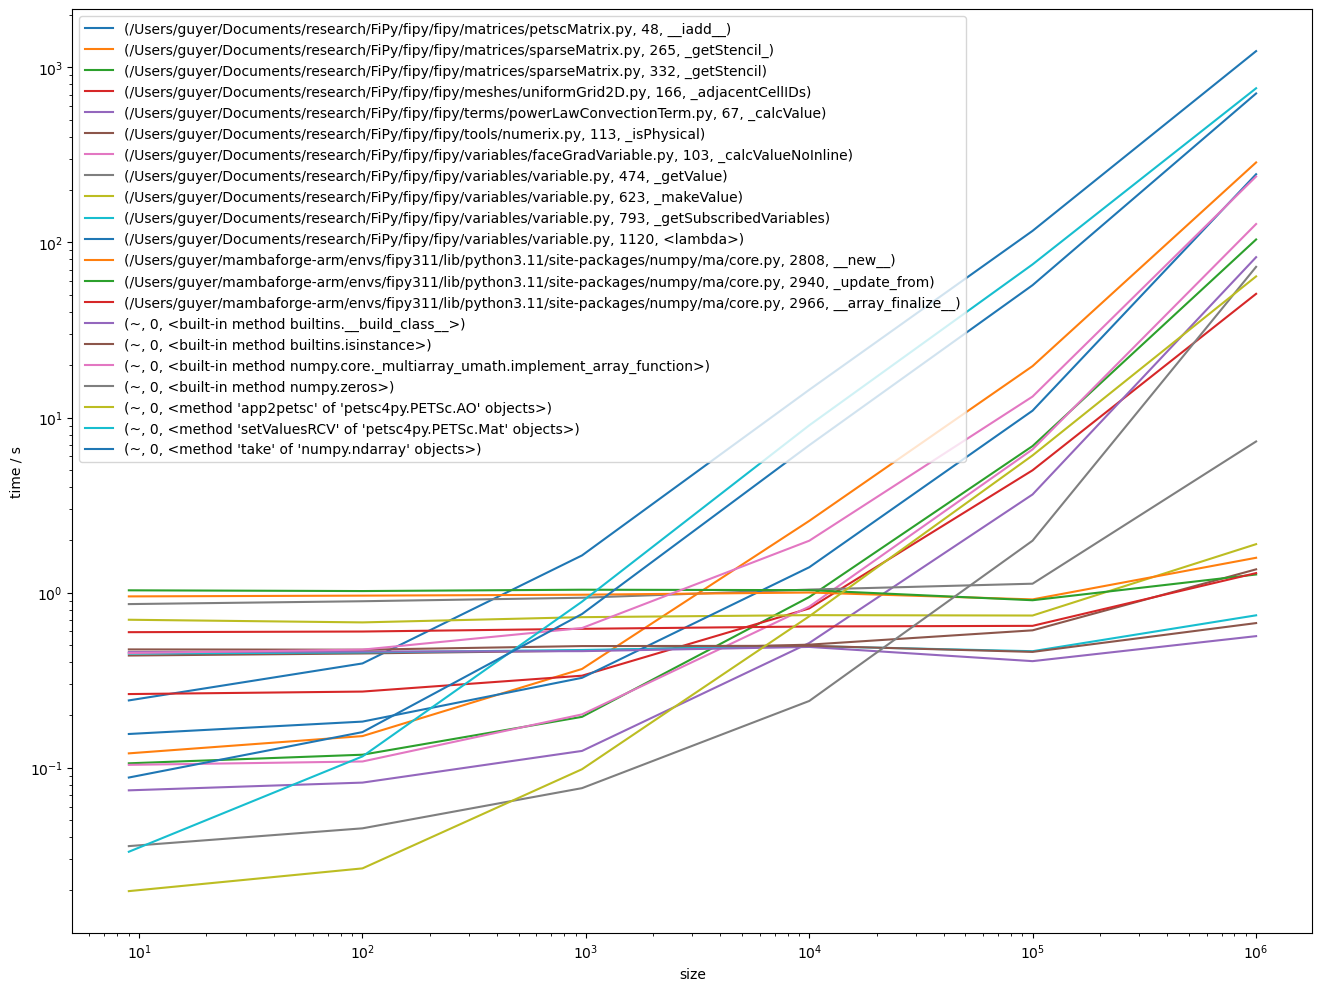

In [16]:
kv = []

for size in [9, 100, 961, 10000, 99856, 1000000]:
    p = pstats.Stats((results_path / problem_name
                      / f"macOS32fb4fc/petsc/LinearGMRESSolver/JacobiPreconditioner/{size}/profile-0.prof").as_posix())

    for k, v in p.stats.items():
        kv.append([size, k, v[2]])
    
df = pd.DataFrame(kv, columns=["size", "function", "tottime"])

functions = set(df.sort_values(by="tottime", ascending=False).groupby("size").head(10)["function"])

fig, ax = plt.subplots(figsize=(16,12))

for label, df2 in df[df["function"].isin(functions)].groupby("function"):
    df2.plot(x="size", y="tottime", ax=ax, loglog=True, label=label)
plt.legend()
_ = plt.ylabel("time / s")

- A collection of `numpy` calls (`_update_from()`, `__new__()`, `__array_finalize__()`, ...) run at essentially fixed time.
- PETSc calls scale down to ~100 cells
- 1000000-cell run was done at a different time than other runs and run conditions may not be the same

In [17]:
for n in range(1,len(set(df["function"]))):
    nfunctions = set(df.sort_values(by="tottime", ascending=False).groupby("size").head(n)["function"])

    if ('~', 0, "<method 'solve' of 'petsc4py.PETSc.KSP' objects>") in nfunctions:
        break

print(f"{n-1} other functions are slower than `solve()`")

25 other functions are slower than `solve()`


## How many times is each function called?

In [19]:
p = pstats.Stats((results_path / problem_name / f"macOS32fb4fc/petsc/LinearGMRESSolver/JacobiPreconditioner/9/profile-0.prof").as_posix())

In [20]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py', 2940, '_update_from')]

(431391,
 431391,
 1.031188135,
 1.467045398,
 {('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   2966,
   '__array_finalize__'): (431391, 431391, 1.031188135, 1.467045398)})

In [21]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py', 2808, '__new__')]

(431390,
 431390,
 0.951942291,
 4.494680144,
 {('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   8086,
   'asanyarray'): (1, 1, 2.458e-06, 1.2042000000000001e-05),
  ('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   6637,
   'array'): (431389, 431389, 0.9519398330000001, 4.494668102)})

In [22]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py', 2966, '__array_finalize__')]

(431391,
 431391,
 0.594635334,
 2.510081837,
 {('~', 0, "<method 'view' of 'numpy.ndarray' objects>"): (431390,
   431390,
   0.594634208,
   2.5100765870000004),
  ('~', 0, "<method 'view' of 'numpy.generic' objects>"): (1,
   1,
   1.126e-06,
   5.2500000000000006e-06)})

In [23]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/matrices/petscMatrix.py', 48, '__iadd__')]

(12000,
 12000,
 0.24237978000000002,
 0.25326512700000003,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/terms/binaryTerm.py',
   16,
   '_buildAndAddMatrices'): (12000,
   12000,
   0.24237978000000002,
   0.25326512700000003)})

In [24]:
p.stats[('~', 0, "<method 'setValuesRCV' of 'petsc4py.PETSc.Mat' objects>")]

(36000,
 36000,
 0.033124417,
 0.033124417,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/matrices/petscMatrix.py',
   189,
   '_setRCV'): (36000, 36000, 0.033124417, 0.033124417)})

In [25]:
p.stats[('~', 0, "<method 'solve' of 'petsc4py.PETSc.KSP' objects>")]

(3000,
 3000,
 0.065092312,
 0.065092312,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/solvers/petsc/petscKrylovSolver.py',
   153,
   '_solve_'): (3000, 3000, 0.065092312, 0.065092312)})

numpy calls are made 35x for every PETSc matrix call and 140x every `solve()`

## Questions

- What about other solvers?
- Is this a fixed cost per run or per step/sweep?
    - Runs for `macOS32fb4fc` were (mistakenly) done for 600 steps. The results in [analyze_binary.py](analyze_binary.py) were done for 2(?) steps and show the same trends. So it seems to be a fixed cost per step/sweep.
- Are we recreating arrays when we should be reusing them?
- Why is building so slow, relative to solving, even for 1000000 elements?
    - How does raw `petsc4py` (or C?) compare? Use bookclub examples?
- What about nucleation?

In [26]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py', 2966, '__array_finalize__')]

(431391,
 431391,
 0.594635334,
 2.510081837,
 {('~', 0, "<method 'view' of 'numpy.ndarray' objects>"): (431390,
   431390,
   0.594634208,
   2.5100765870000004),
  ('~', 0, "<method 'view' of 'numpy.generic' objects>"): (1,
   1,
   1.126e-06,
   5.2500000000000006e-06)})

In [27]:
p.stats[('~', 0, "<method 'view' of 'numpy.ndarray' objects>")]

(431391,
 431391,
 0.156354134,
 2.6664307210000002,
 {('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   3680,
   '_get_data'): (1, 1, 2.09e-07, 2.09e-07),
  ('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   2808,
   '__new__'): (431390, 431390, 0.156353925, 2.6664305120000003)})

In [28]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   2808,
   '__new__')]

(431390,
 431390,
 0.951942291,
 4.494680144,
 {('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   8086,
   'asanyarray'): (1, 1, 2.458e-06, 1.2042000000000001e-05),
  ('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   6637,
   'array'): (431389, 431389, 0.9519398330000001, 4.494668102)})

In [29]:
p.stats[('/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/numpy/ma/core.py',
   6637,
   'array')]

(431389,
 431389,
 0.377042694,
 4.871710796,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   623,
   '_makeValue'): (305332, 305332, 0.271637459, 3.475652423),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/tools/numerix.py',
   262,
   'sum'): (39055, 39055, 0.031235897000000002, 0.42340060100000004),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/tools/numerix.py',
   602,
   'take'): (87002, 87002, 0.074169338, 0.972657772)})

In [30]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   623,
   '_makeValue')]

(317368,
 317368,
 0.7002500770000001,
 4.459096133,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   620,
   '_setValueInternal'): (313767, 313767, 0.690624993, 4.405414048),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   671,
   'setValue'): (3601, 3601, 0.009625084, 0.053682085000000004)})

In [31]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   620,
   '_setValueInternal')]

(313767,
 313767,
 0.15002237000000002,
 4.555436418,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   54,
   '__init__'): (49400, 49400, 0.023734302000000002, 0.746323191),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   474,
   '_getValue'): (264367, 264367, 0.126288068, 3.809113227)})

In [32]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   474,
   '_getValue')]

(184097,
 640189,
 0.860269703,
 12.139570488,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/cellVariable.py',
   467,
   'updateOld'): (601, 601, 0.000606064, 0.0011540460000000002),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/meshVariable.py',
   110,
   '_globalToLocalValue'): (12636, 12636, 0.014815244000000002, 0.107259556),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   219,
   '_getUnit'): (116707, 116704, 0.115148549, 0.544061224),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1339,
   '__len__'): (1, 1, 2.4160000000000002e-06, 8.2334e-05),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1399,
   'ravel'): (21000, 21000, 0.040373279000000005, 5.915831804000001),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   144,
   '__array__'): (21005, 21005, 0.030010795000000003, 1.2991073080000002),
  ('/Users/guyer/Documents/research/Fi

In [33]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/binaryOperatorVariable.py',
   39,
   '_calcValue_')]

(35614,
 161744,
 0.384485746,
 10.237006661,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/binaryOperatorVariable.py',
   54,
   'unit'): (20, 20, 3.8583e-05, 9.896e-05),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/operatorVariable.py',
   48,
   '_calcValue'): (161724, 35594, 0.38444716300000004, 10.236907701)})

In [34]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/operatorVariable.py',
   48,
   '_calcValue')]

(48644,
 234373,
 0.21800359500000002,
 10.936267594,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/unaryOperatorVariable.py',
   42,
   'unit'): (8, 8, 3.542e-06, 0.000495999),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   474,
   '_getValue'): (234365, 48644, 0.21800005300000003, 10.935970679)})

In [35]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   474,
   '_getValue')]

(184097,
 640189,
 0.860269703,
 12.139570488,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/cellVariable.py',
   467,
   'updateOld'): (601, 601, 0.000606064, 0.0011540460000000002),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/meshVariable.py',
   110,
   '_globalToLocalValue'): (12636, 12636, 0.014815244000000002, 0.107259556),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   219,
   '_getUnit'): (116707, 116704, 0.115148549, 0.544061224),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1339,
   '__len__'): (1, 1, 2.4160000000000002e-06, 8.2334e-05),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1399,
   'ravel'): (21000, 21000, 0.040373279000000005, 5.915831804000001),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   144,
   '__array__'): (21005, 21005, 0.030010795000000003, 1.2991073080000002),
  ('/Users/guyer/Documents/research/Fi

In [36]:
p.stats[('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   219,
   '_getUnit')]

(116704,
 116707,
 0.063930608,
 0.653624771,
 {('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/operatorVariable.py',
   17,
   '__init__'): (15689, 15689, 0.007744786000000001, 0.039161362000000005),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1449,
   '__getitem__'): (12626, 12625, 0.008554441000000001, 0.391486098),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   988,
   '_UnaryOperatorVariable'): (12630,
   12630,
   0.006470572000000001,
   0.032980017),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   205,
   '_unitAsOne'): (69703, 69703, 0.037814143, 0.17113224300000002),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/solvers/solver.py',
   188,
   '_solve'): (3000, 3000, 0.00193263, 0.010109114),
  ('/Users/guyer/Documents/research/FiPy/fipy/fipy/variables/variable.py',
   1049,
   '_BinaryOperatorVariable'): (3059,
   3059,
   0.001414036,
   0.008762813000000001)})